In [ ]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [ ]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


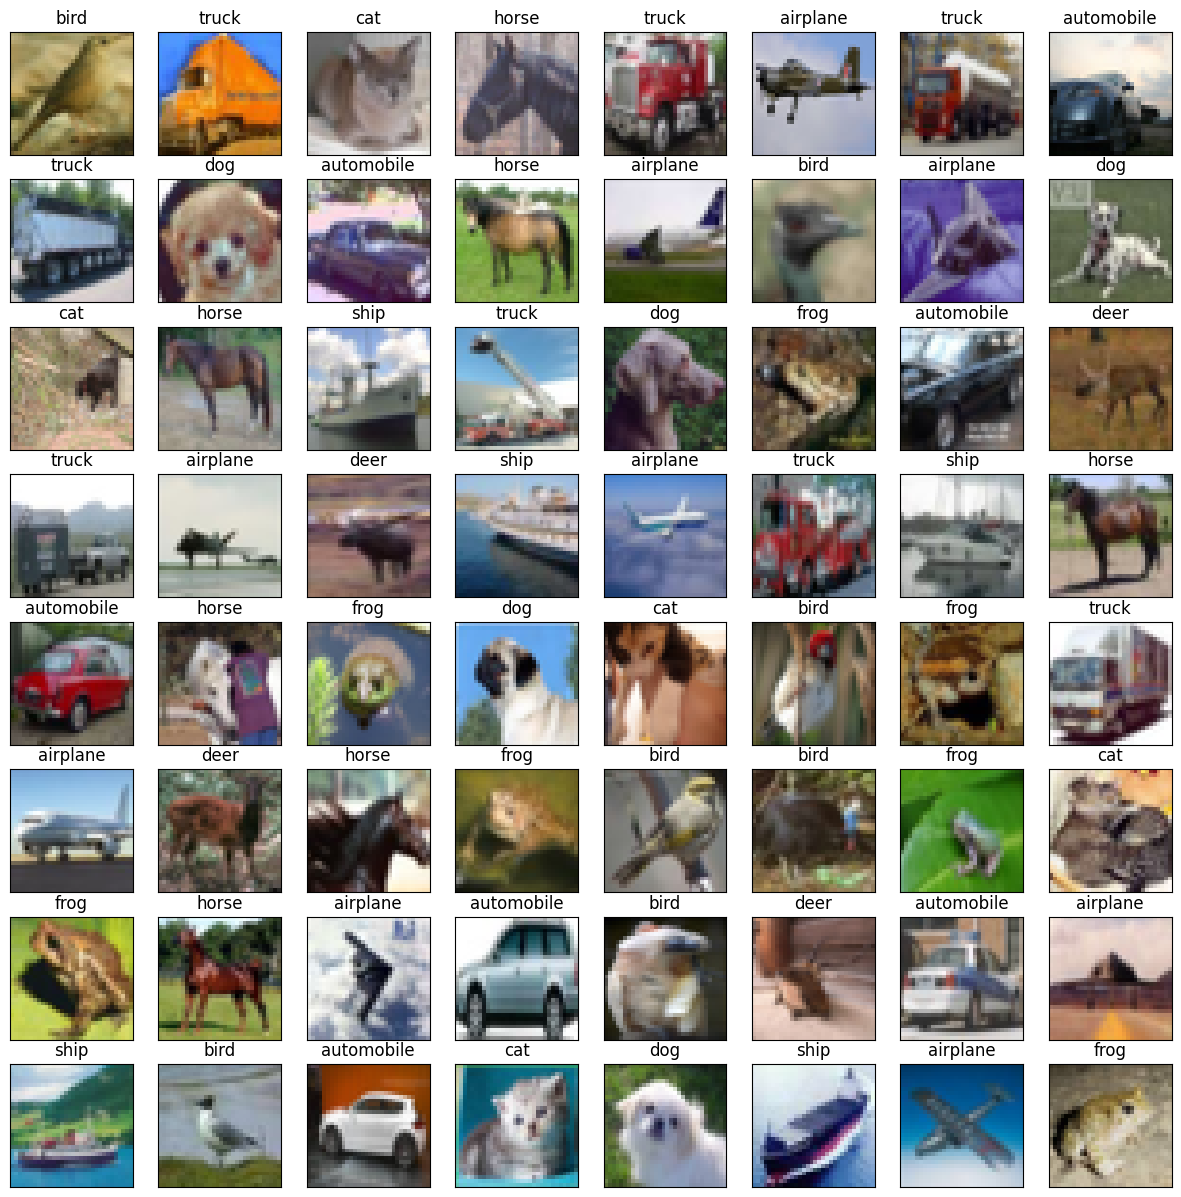

In [ ]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

Normalization of Image Data

In [ ]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

One-Hot Encoding of Labels

In [ ]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,

    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,

    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,

    # Randomly flip images horizontally
    horizontal_flip=True,

    # Zoom images in by up to 10%
    zoom_range=0.1,

    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,

    # Channel shift intensity
    channel_shift_range=0.1,
)

Define CNN Model Architecture

In [ ]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay),
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

Training the CNN Model

In [ ]:
# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 50

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping],
          verbose=2)



Epoch 1/50
704/704 - 70s - 99ms/step - accuracy: 0.6381 - loss: 1.1533 - val_accuracy: 0.6740 - val_loss: 1.0733 - learning_rate: 5.0000e-04
Epoch 2/50
704/704 - 49s - 69ms/step - accuracy: 0.6717 - loss: 1.0784 - val_accuracy: 0.6552 - val_loss: 1.1898 - learning_rate: 5.0000e-04
Epoch 3/50
704/704 - 81s - 115ms/step - accuracy: 0.6951 - loss: 1.0047 - val_accuracy: 0.7208 - val_loss: 0.9362 - learning_rate: 5.0000e-04
Epoch 4/50
704/704 - 47s - 66ms/step - accuracy: 0.7121 - loss: 0.9629 - val_accuracy: 0.7392 - val_loss: 0.8914 - learning_rate: 5.0000e-04
Epoch 5/50
704/704 - 81s - 115ms/step - accuracy: 0.7197 - loss: 0.9525 - val_accuracy: 0.7706 - val_loss: 0.8105 - learning_rate: 5.0000e-04
Epoch 6/50
704/704 - 47s - 67ms/step - accuracy: 0.7345 - loss: 0.9163 - val_accuracy: 0.7574 - val_loss: 0.8548 - learning_rate: 5.0000e-04
Epoch 7/50
704/704 - 47s - 67ms/step - accuracy: 0.7431 - loss: 0.8943 - val_accuracy: 0.7800 - val_loss: 0.7917 - learning_rate: 5.0000e-04
Epoch 8/50


Visualizing the Learning Curves

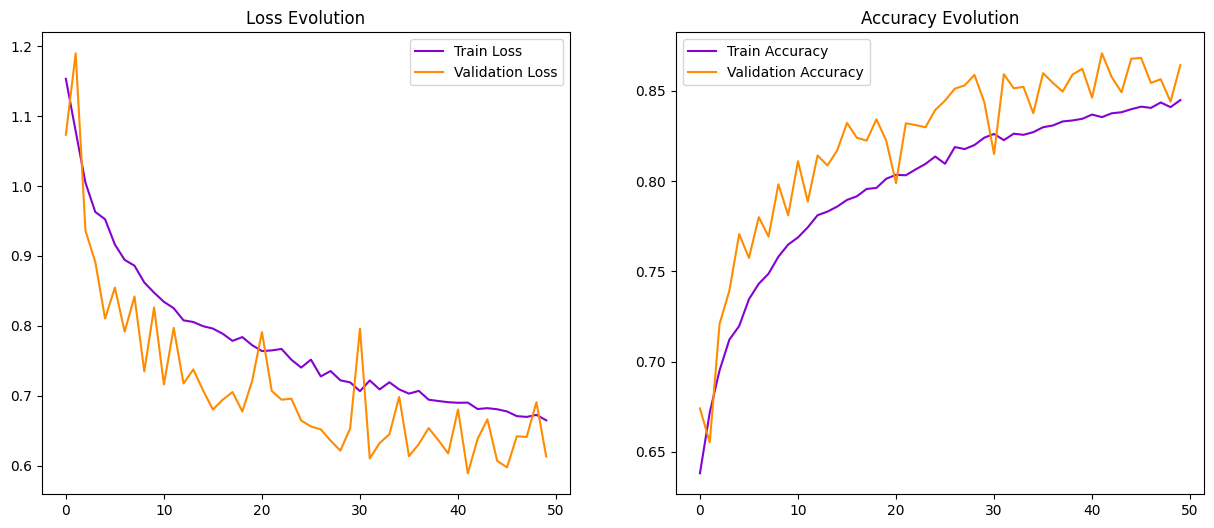

In [ ]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

Evaluating the Optimal Model on Test Data

In [ ]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8715 - loss: 0.6000

Test Accuracy: 0.8700000047683716
Test Loss:     0.6028872728347778


Performance on an Out-of-Dataset Image

In [ ]:
# Fetch the raw image from GitHub
url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

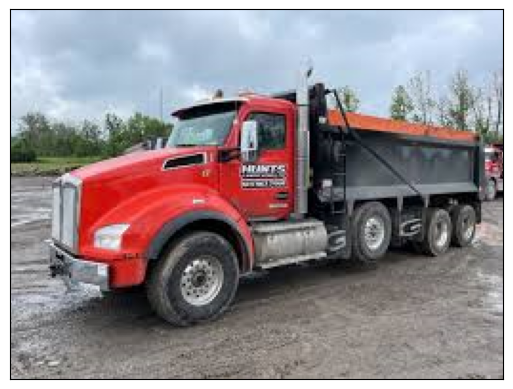

In [ ]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [ ]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [ ]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  truck


In [ ]:
# Fetch the raw image from GitHub
url = "https://i.dawn.com/primary/2017/10/59d9915569cd2.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

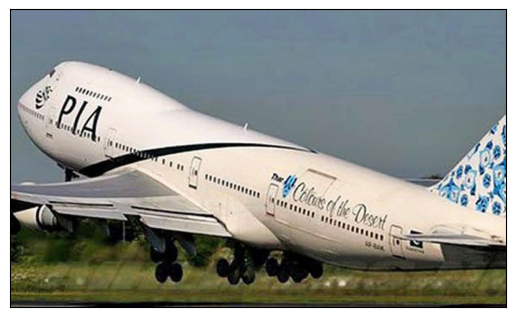

In [ ]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))
plt.show()

In [ ]:
image.shape

(1, 32, 32, 3)

In [ ]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [ ]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  airplane


**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

# Set weight decay for L2 regularization
weight_decay = 0.0001

# Define input shape
input_shape = X_train.shape[1:]  # e.g., (64, 64, 3)

# Load ResNet50 base model (without top layer)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=input_shape),
    pooling=None
)

# Freeze the base model initially (fine-tuning comes later)
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(weight_decay))(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)  # 10 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))


Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3245 - loss: 1.8854 - val_accuracy: 0.3852 - val_loss: 1.7703
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3231 - loss: 1.8783 - val_accuracy: 0.3844 - val_loss: 1.7738
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.3237 - loss: 1.8726 - val_accuracy: 0.3902 - val_loss: 1.7616
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3300 - loss: 1.8683 - val_accuracy: 0.3950 - val_loss: 1.7611
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3287 - loss: 1.8748 - val_accuracy: 0.3918 - val_loss: 1.7674
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3349 - loss: 1.8585 - val_accuracy: 0.3970 - val_loss: 1.7496
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3349 - loss: 1.8501 - val_accuracy: 0.3958 - val_loss: 1.7503
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3349 - loss: 